Шаг 1: Сбор данных

Предположим, у вас есть данные для 100 пользователей:
50 пользователей получили рекламное предложение (группа воздействия).
50 пользователей не получили предложение (контрольная группа).

In [1]:
import pandas as pd
import numpy as np

# генерация данных для 100 пользователей
np.random.seed(42)
n = 100
treatment = np.array([1]*50 + [0]*50)
outcome = np.concatenate([np.random.choice([1, 0], p=[0.2, 0.8], size=50),
                          np.random.choice([1, 0], p=[0.1, 0.9], size=50)])
uplift_prediction = np.random.rand(n)

# создание DataFrame
data = {
    'user_id': range(1, n+1),
    'treatment': treatment,
    'outcome': outcome,
    'uplift_prediction': uplift_prediction
}

df = pd.DataFrame(data)
print(df.head())


   user_id  treatment  outcome  uplift_prediction
0        1          1        0           0.031429
1        2          1        0           0.636410
2        3          1        0           0.314356
3        4          1        0           0.508571
4        5          1        1           0.907566


Шаг 2: Сортировка данных по uplift_prediction

In [2]:
# сортировка данных по uplift_prediction
df = df.sort_values(by='uplift_prediction', ascending=False).reset_index(drop=True)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0       55          0        0           0.985650
1       40          1        0           0.971782
2       41          1        1           0.962447
3       35          1        0           0.942910
4       79          0        0           0.936730


Шаг 3: Инициализация переменных для расчёта CGain и Random

In [3]:
# инициализация переменных
nt = 0
nt_1 = 0
nc = 0
nc_1 = 0
cgain = []
random = []
optimum = []
incremental_purchases = 0
opt_incremental_purchases = df['outcome'].sum()

In [4]:
opt_incremental_purchases

22

Шаг 4: Расчёт CGain, Random и Optimum

Optimum — максимальное значение uplift, которое мы можем получить на выборке.

In [5]:
# расчёт CGain, Random и Optimum
for i, row in df.iterrows():
    if row['treatment'] == 1:
        nt += 1
        if row['outcome'] == 1:
            nt_1 += 1
            incremental_purchases += 1
    else:
        nc += 1
        if row['outcome'] == 1:
            nc_1 += 1

    cgain.append(incremental_purchases) #растем если treatment=1 и outcome=1, иначе 0
    random.append(opt_incremental_purchases * (i + 1) / len(df)) #равномерно растем
    optimum.append(min(opt_incremental_purchases, (i + 1) * 1.0)) #сразу растем

In [6]:
print(cgain)
print(random)
print(optimum)

[0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
[0.22, 0.44, 0.66, 0.88, 1.1, 1.32, 1.54, 1.76, 1.98, 2.2, 2.42, 2.64, 2.86, 3.08, 3.3, 3.52, 3.74, 3.96, 4.18, 4.4, 4.62, 4.84, 5.06, 5.28, 5.5, 5.72, 5.94, 6.16, 6.38, 6.6, 6.82, 7.04, 7.26, 7.48, 7.7, 7.92, 8.14, 8.36, 8.58, 8.8, 9.02, 9.24, 9.46, 9.68, 9.9, 10.12, 10.34, 10.56, 10.78, 11.0, 11.22, 11.44, 11.66, 11.88, 12.1, 12.32, 12.54, 12.76, 12.98, 13.2, 13.42, 13.64, 13.86, 14.08, 14.3, 14.52, 14.74, 14.96, 15.18, 15.4, 15.62, 15.84, 16.06, 16.28, 16.5, 16.72, 16.94, 17.16, 17.38, 17.6, 17.82, 18.04, 18.26, 18.48, 18.7, 18.92, 19.14, 19.36, 19.58, 19.8, 20.02, 20.24, 20.46, 20.68, 20.9, 21.12, 21.34, 21.56, 21.78, 22.0]
[1.0, 2.0, 3.0, 4.

Шаг 5: Расчёт метрик

In [7]:
from sklearn.metrics import auc

# расчёт площади под кривыми
qini_auc = auc(range(1, len(cgain) + 1), cgain)
random_auc = auc(range(1, len(random) + 1), random)

# расчёт Qini Score
qini_score = qini_auc - random_auc

# вывод Qini Score
print(f'Qini Score: {qini_score}')

Qini Score: -264.3900000000001


In [8]:
range(1, len(cgain) + 1)

range(1, 101)

Шаг 6: Построение графика

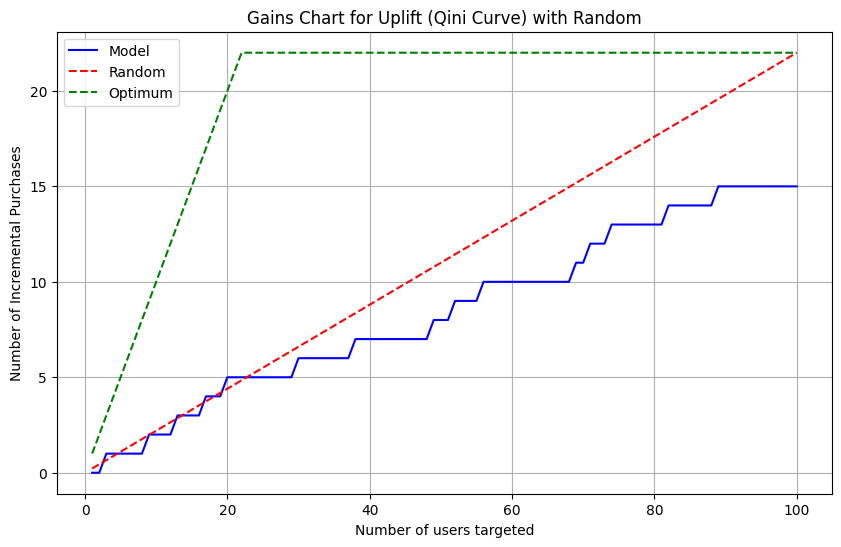

In [9]:
import matplotlib.pyplot as plt

# построение графиков
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cgain) + 1), cgain, label='Model', color='blue')
plt.plot(range(1, len(random) + 1), random, label='Random', color='red', linestyle='--')
plt.plot(range(1, len(optimum) + 1), optimum, label='Optimum', color='green', linestyle='--')
plt.xlabel('Number of users targeted')
plt.ylabel('Number of Incremental Purchases')
plt.title('Gains Chart for Uplift (Qini Curve) with Random')
plt.legend()
plt.grid(True)
plt.show()

# задание

In [10]:
# Задание

# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
# загружаем DataFrame
discount = pd.read_csv("discountuplift.csv", sep="\t")
discount

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,5,104.04,1,0,1,0,0,0,1,0,1,0,0.443421,0.063945,0.450813,0.041821,-0.082280,0
12780,3,558.27,1,0,1,1,0,1,0,0,0,1,0.689539,0.027868,0.224104,0.058488,0.336249,2
12781,11,211.30,1,0,0,0,1,0,0,0,0,1,0.421402,0.076274,0.396279,0.106045,0.115697,0
12782,7,335.62,1,0,1,0,0,1,0,0,0,1,0.531513,0.019835,0.381351,0.067301,0.228063,0


В данном датасете нас интересуют 2 колонки: uplift_score и target_class.
Расшифровка target_class:
 - 0 — контрольная выборка, не купили товар ($y_c=0$, в наших терминах)
 - 1 — контрольная выборка, купили товар ($y_c=1$, в наших терминах)
 - 2 — выборка с воздействием (скидка), не купили товар ($y_t=0$, в наших терминах);
 - 3 — выборка с воздействием (скидка), купили товар ($y_t=1$, в наших терминах).

In [11]:
discount['target_class'].value_counts()

target_class
0    5688
2    5218
3    1174
1     704
Name: count, dtype: int64

In [12]:
#разбираюсь как работает функция
ranked = discount.sort_values(by="uplift_score", ascending=False).reset_index()
    
N_c = sum(ranked['target_class'] <= 1)
N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
ranked['n_c1'] = 0
ranked['n_t1'] = 0
ranked.loc[ranked.target_class == 1,'n_c1'] = 1
ranked.loc[ranked.target_class == 3,'n_t1'] = 1

ranked



,index,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,...,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,n_c1,n_t1
0,11175,1,1411.37,1,1,1,0,0,1,0,...,0,0,0.379081,0.021113,0.111872,0.487934,1.521461,0,0,0
1,4527,1,2080.11,1,1,1,0,0,1,0,...,0,0,0.076478,0.016237,0.118993,0.788292,1.387446,0,0,0
2,10645,2,1111.60,1,0,1,1,1,0,0,...,0,0,0.348880,0.013401,0.198635,0.439084,1.303066,2,0,0
3,12633,1,1927.91,1,1,1,0,0,1,0,...,1,0,0.833439,0.016495,0.050645,0.099421,1.286218,1,1,0
4,7874,1,613.11,1,0,1,0,0,1,0,...,0,0,0.300334,0.023053,0.207353,0.469261,1.244516,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,10668,3,1829.32,1,1,1,1,1,0,0,...,0,0,0.117363,0.823245,0.044260,0.015133,-1.240869,2,0,0
12780,10764,5,1667.27,1,1,1,1,0,1,0,...,0,0,0.104995,0.762437,0.098371,0.034197,-1.242003,2,0,0
12781,1012,1,1820.49,1,0,1,0,0,1,0,...,0,1,0.109151,0.635398,0.237430,0.018021,-1.565707,1,1,0
12782,11383,1,1661.71,1,1,1,1,0,0,1,...,0,1,0.036550,0.199102,0.754591,0.009757,-1.664264,2,0,0


In [13]:
ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

ranked

,index,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,...,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,n_c1,n_t1,n_c1/nc,n_t1/nt
0,11175,1,1411.37,1,1,1,0,0,1,0,...,0.379081,0.021113,0.111872,0.487934,1.521461,0,0,0,0.000000,0.000000
1,4527,1,2080.11,1,1,1,0,0,1,0,...,0.076478,0.016237,0.118993,0.788292,1.387446,0,0,0,0.000000,0.000000
2,10645,2,1111.60,1,0,1,1,1,0,0,...,0.348880,0.013401,0.198635,0.439084,1.303066,2,0,0,0.000000,0.000000
3,12633,1,1927.91,1,1,1,0,0,1,0,...,0.833439,0.016495,0.050645,0.099421,1.286218,1,1,0,0.000156,0.000000
4,7874,1,613.11,1,0,1,0,0,1,0,...,0.300334,0.023053,0.207353,0.469261,1.244516,0,0,0,0.000156,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,10668,3,1829.32,1,1,1,1,1,0,0,...,0.117363,0.823245,0.044260,0.015133,-1.240869,2,0,0,0.109981,0.183667
12780,10764,5,1667.27,1,1,1,1,0,1,0,...,0.104995,0.762437,0.098371,0.034197,-1.242003,2,0,0,0.109981,0.183667
12781,1012,1,1820.49,1,0,1,0,0,1,0,...,0.109151,0.635398,0.237430,0.018021,-1.565707,1,1,0,0.110138,0.183667
12782,11383,1,1661.71,1,1,1,1,0,0,1,...,0.036550,0.199102,0.754591,0.009757,-1.664264,2,0,0,0.110138,0.183667


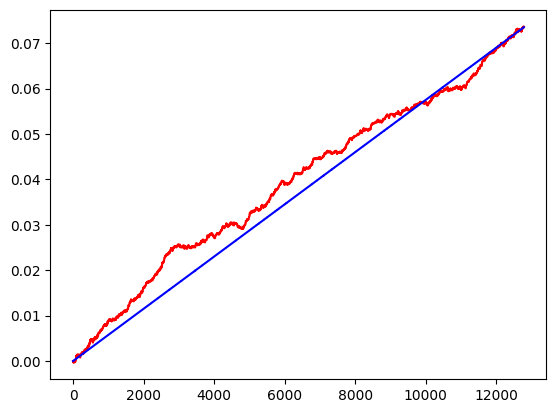

33.17995

In [14]:

# реализуем подсчёт Qini Score:
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в порядке убывания
    ranked = discount.sort_values(by="uplift_score", ascending=False).reset_index()
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False)* ranked["uplift"].iloc[-1],5,)
    ranked["n"] = range(len(ranked))
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(discount) 